# Get and explore dataset

In [1]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import re

In [2]:
# Make results reproducible - set random seed
from numpy.random import seed
seed(42)

In [3]:
negative_file = "negative.txt"
positive_file = "positive.txt"

In [4]:
# Do not modify - helper function to load and preprocess data
def filter_words(line):    
    line = re.sub(r'[^\w\s]','',line.rstrip())
    words = line.split(" ") 
    words = [i.lower() for i in words if i]      
    return " ".join(words)

def load_data(filename):
    thefile = open(filename, 'r') 
    lines = thefile.readlines() 

    data = []
    for l in range(0,len(lines)): 
        if(lines[l-1].strip() == "<title>"): 
            theline = filter_words(lines[l])
            if(len(theline) < 50):
                data.append(theline)            
            
    return data

# Helper function to convert categorical data to class label
def to_word_label(y):
    y = to_class(y)   
    return ["positive" if i==0 else "negative" for i in y]

# Helper function to convert class label to numeric label
def to_numeric_label(y):
  return [0 if i=="positive" else 1 for i in word_labels]

# Helper function: this function needs to be called before sending arrays to sklearn metrics,
# it converts back to class form from categorical form. ie: [1,0] --> 0, [0,1] --> 1
def to_class(y):
    return np.argmax(y,axis=1) 

In [5]:
positive = load_data(positive_file)
negative = load_data(negative_file)

print(positive[0:10])
print(negative[0:10])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book', 'to the point and beautifully illustrated', 'at least somebody has got it', 'beautifully written heartwarming story', 'an excellent cookbook full of delicious recipes', 'an outstanding resource']
['horrible book horrible', 'shallow selfindulgence', 'horrible book horrible', 'disappointment', 'a disappointing mess', 'save your money there are better books out there', 'thank you but no thanks', 'unendurable', 'the hard way', 'some good info among the political commercial']


In [6]:
# Do not modify - Combines the positive and negative reviews into a single list and create labels
data = positive + negative
word_labels = ["positive"] * len(positive) + ["negative"] * len(negative) 

# Converts labels to numbers in one-hot encoding - [1, 0] (positive) or [0, 1] (negative)
from keras.utils import to_categorical
labels  = to_categorical(to_numeric_label(word_labels))

C:\Users\ryan.harrison\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Mean Review Size: 4.336865588399331
Standard Deviation: 2.16967555545863


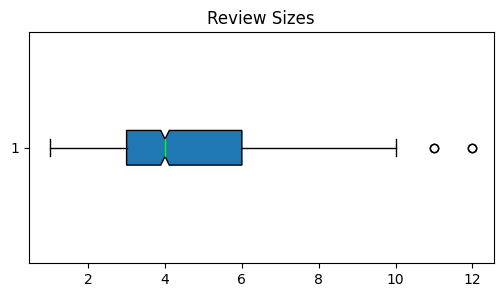

In [7]:
# Write some code to investigate the dataset. 
# - Calculate and report the mean review size, its standard deviation and create a boxplot.
review_sizes = [len(i.split(" ")) for i in data]
mean_review_size = np.mean(review_sizes)
standard_deviation = np.std(review_sizes)
print("Mean Review Size: {}\nStandard Deviation: {}".format(mean_review_size, standard_deviation))

# Create the boxplot
boxplot_fig = plt.figure(figsize=(6, 3))
box_1 = plt.boxplot(review_sizes, vert=0, patch_artist=True, notch=True)
plt.setp(box_1["medians"], color="#00FF00")
plt.title("Review Sizes")
plt.show()

We can see here that the mean review size is around 4, with the longest being around 6 and the shortest around 3. This means the deviation is quite small overall, so we should be able to get reasonably accurate results for most reviews without needing add/ trim too much data. There are also just 2 outliers with 10+ words.

In [8]:
# - Calculate the number of unique words in the dataset
unique_words = []
for each_review in data:
    # Split by spaces to get each word in each review.
    words = each_review.split(" ")
    unique_words.extend(words)
    
# Convert list to a set to remove duplicates.
unique_words = list(set(unique_words))
print("Total unique words: {}".format(len(unique_words)))

Total unique words: 2559


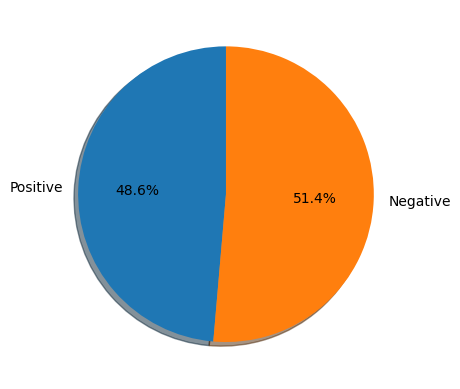

In [9]:
# - Calculate how many positive vs negative reviews we have to see the split.
piechart_fig, piechart_ax = plt.subplots()
piechart_ax.pie([len(positive), len(negative)], labels=["Positive", "Negative"], autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

The split seems to favour negative more than positive, but only slightly.

In [10]:
# Do not modify - Tokenize the vocabulary 
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=25)

tokenizer.fit_on_texts(data) #create the vocabularry

tokenized_data = tokenizer.texts_to_sequences(data) #tokenize the data using the vocabulary

vocab_size = len(tokenizer.word_index) + 1 

# Compare a sample of the data before and after tokenization
print(data[0:5])
print(tokenized_data[0:5])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book']
[[18, 4, 2, 19], [2, 4, 2], [], [6, 4], [1, 12, 3]]


# Pre-processing

In [11]:
# Pre-processing
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, BatchNormalization, SpatialDropout1D

# Write some code to pre-process the data so that each review is the same length
trimmed_data = keras.preprocessing.sequence.pad_sequences(tokenized_data, maxlen=4, dtype="int32", padding="post", value=0.0)
print(trimmed_data[0:5])

[[18  4  2 19]
 [ 2  4  2  0]
 [ 0  0  0  0]
 [ 6  4  0  0]
 [ 1 12  3  0]]


In [12]:
from sklearn.model_selection import train_test_split
# Write some code to split the data into a training and test set. Make sure you shuffle the data. Use 20% for the test set.
X = trimmed_data
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

In [13]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Fill in the following function so it
# - makes a prediction for the test set given the model
# - reports the precision, recall and f1 score. Also print the confusion matrix. 
# You will need to use the helper to_class function to convert y_pred and y_test before supplying them to the sklearn functions.

def assess_model(input_model, test_X, test_y):
    # Make predictions on the model.
    y_pred = input_model.predict(test_X)
    
    # Get the precision.
    precision = precision_score(to_class(test_y), to_class(y_pred))
    
    # Get the recall.
    recall = recall_score(to_class(test_y), to_class(y_pred))
    
    # Get the f1 score.
    f1 = f1_score(to_class(test_y), to_class(y_pred))
    
    # Get the confusion matrix.
    confusion = confusion_matrix(to_class(test_y), to_class(y_pred))
    
    # Print the results
    print("precision_score:\n{}\n\nrecall_score:\n{}\n\nf1_score:\n{}\n\nconfusion_matrix:\n{}\n\n".format(precision,
                                                                                                           recall,
                                                                                                           f1,
                                                                                                           confusion))

# Build and tune model

Define network architecture

In [14]:
# Create model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=len(data), output_dim=1000, input_length=4))

# Spatial Dropout
model.add(SpatialDropout1D(0.2))

# Batch Normalisation
model.add(BatchNormalization())

# LSTM
model.add(LSTM(32))

# Dense
model.add(Dense(2, activation="softmax"))

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Display
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 1000)           1793000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 4, 1000)          0         
 ropout1D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 4, 1000)          4000      
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 32)                132224    
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 1,929,290
Trainable params: 1,927,290
Non-

Train model

In [15]:
# Train
model_history = model.fit(X_train, y_train, epochs=5, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/5
144/144 [==============================] - 3s 13ms/step - loss: 0.6875 - accuracy: 0.5621 - val_loss: 0.6849 - val_accuracy: 0.5571
Epoch 2/5
144/144 [==============================] - 2s 11ms/step - loss: 0.6599 - accuracy: 0.6011 - val_loss: 0.6726 - val_accuracy: 0.5822
Epoch 3/5
144/144 [==============================] - 2s 11ms/step - loss: 0.6496 - accuracy: 0.6109 - val_loss: 0.6601 - val_accuracy: 0.6072
Epoch 4/5
144/144 [==============================] - 2s 11ms/step - loss: 0.6409 - accuracy: 0.6227 - val_loss: 0.6606 - val_accuracy: 0.6100
Epoch 5/5
144/144 [==============================] - 2s 11ms/step - loss: 0.6399 - accuracy: 0.6283 - val_loss: 0.6668 - val_accuracy: 0.6072


Examine performance of model

In [16]:
assess_model(input_model=model, test_X=X_test, test_y=y_test)

12/12 [==============================] - 0s 2ms/step
precision_score:
0.5846774193548387

recall_score:
0.7923497267759563

f1_score:
0.6728538283062645

confusion_matrix:
[[ 73 103]
 [ 38 145]]




#### output_dim 10:

precision_score:
0.5829383886255924

recall_score:
0.6721311475409836

f1_score:
0.6243654822335025

confusion_matrix:
[[ 88  88]
 [ 60 123]]

#### output_dim 25: 

precision_score:
0.583710407239819

recall_score:
0.7049180327868853

f1_score:
0.6386138613861386

confusion_matrix:
[[ 84  92]
 [ 54 129]]
 
#### output_dim 100:
 
 precision_score:
0.5796460176991151

recall_score:
0.7158469945355191

f1_score:
0.6405867970660146

confusion_matrix:
[[ 81  95]
 [ 52 131]]
 
#### output_dim 1000:

precision_score:
0.5731225296442688

recall_score:
0.7923497267759563

f1_score:
0.6651376146788991

confusion_matrix:
[[ 68 108]
 [ 38 145]]


Plot graphs for accuracy and loss

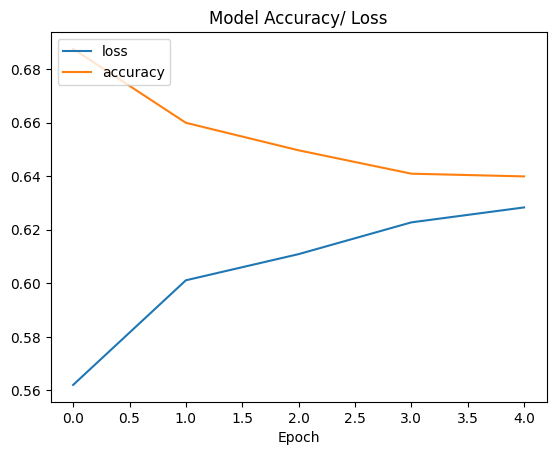

In [17]:
# Get the accuracy from the history of the model and plot.
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["loss"])
plt.title("Model Accuracy/ Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "accuracy"], loc='upper left')
plt.show()

# Make a prediction

In [18]:
# This is a very small set of completed new data to use to make predictions.
prediction_data = ["this book is fabulous","i hated this book", "the best", "no good", "okay"]
tokenized = tokenizer.texts_to_sequences(prediction_data)
padded = keras.preprocessing.sequence.pad_sequences(tokenized, padding="post", maxlen=4)

# Supply this data to each of your models and see how it does. 
# You can call the helper function "to_word_label" to map the output of the model to the name of the
# class it was predicted to belong to.
custom_predictions = model.predict(padded)
prediction_results = to_word_label(y=custom_predictions)

1/1 [==============================] - 0s 13ms/step


In [19]:
print(prediction_results)

['negative', 'negative', 'positive', 'positive', 'negative']


output_dim 10: ['negative', 'negative', 'positive', 'positive', 'negative']

output_dim 25: ['negative', 'negative', 'positive', 'positive', 'negative']

output_dim 100: ['negative', 'negative', 'positive', 'positive', 'negative']

output_dim 1000: ['negative', 'negative', 'positive', 'positive', 'negative']

# Custom sentence predictions

In [20]:
# This is a very small set of completed new data to use to make predictions.
prediction_data_2 = ["amazing book", "would not recommend", "would highly recommend", "unlikely success"]
tokenized_2 = tokenizer.texts_to_sequences(prediction_data_2)
padded_2 = keras.preprocessing.sequence.pad_sequences(tokenized_2, padding="post", maxlen=4)

# Supply this data to each of your models and see how it does. 
# You can call the helper function "to_word_label" to map the output of the model to the name of the
# class it was predicted to belong to.
custom_predictions_2 = model.predict(padded_2)
prediction_results_2 = to_word_label(y=custom_predictions_2)

print(prediction_results_2)

1/1 [==============================] - 0s 13ms/step
['positive', 'negative', 'negative', 'negative']


# Summary

The model isn't perfect, but does have a grasp on some positive/ negative comments. As you can see in the custom prediction data, comments such as "unlikely success" and "would highly recommend" seemed to trip up this prediction model. Increasing the output_dim did seem to improve the model slightly. I assumed increasing the epochs would also help, but this ended up being detrimental to the model in the end, so I stuck with 5.